<a href="https://colab.research.google.com/github/AnirudhV03/RUS-UKR-War-Twitter-Sentiment-Analysis/blob/main/Ukraine_Russia_War_Twitter_Sentiment_Analysis_using_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.1 Integrating Kaggle API to Download Dataset Directly from Kaggle.

You can skip this whole block if you have manually downloaded the data from Kaggle and using it.

In [1]:
#@title 1.1.1 Installing Kaggle

!pip install -q kaggle

Download the Kaggle API Key from your Kaggle account. (Settings)

In [2]:
#@title 1.1.2 Installing the Downloaded Kaggle API Key File (.json file)
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anirudhanvinod","key":"3f98118a050ca12b163da056dd02338b"}'}

In [3]:
#@title 1.1.3 Creating Directory
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [4]:
#@title 1.1.4 Selecting Directory
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
#@title 1.1.5 Printing Kaggle Datasets to Check if the Integration is Successful.

! kaggle datasets list

ref                                                             title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
carlmcbrideellis/llm-7-prompt-training-dataset                  LLM: 7 prompt training dataset                    41MB  2023-11-15 07:32:56            887         79  1.0              
thedrcat/daigt-v2-train-dataset                                 DAIGT V2 Train Dataset                            29MB  2023-11-16 01:38:36            405         60  1.0              
thedrcat/daigt-proper-train-dataset                             DAIGT Proper Train Dataset                       119MB  2023-11-05 14:03:25            968        111  1.0              
joebeachcapital/30000-spotify-songs                             30000 Spoti

In [6]:
#@title 1.1.6 Kaggle API Command to Download the Dataset used for this Analysis.


! kaggle datasets download -d towhidultonmoy/russia-vs-ukraine-tweets-datasetdaily-updated

  0% 0.00/2.14M [00:00<?, ?B/s]
100% 2.14M/2.14M [00:00<00:00, 170MB/s]


#1.2 Importing Required Libraries and Dataset

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
import re
from nltk.corpus import stopwords
import string
import numpy as np

!unzip /content/russia-vs-ukraine-tweets-datasetdaily-updated.zip
data = pd.read_csv("/content/filename.csv")
print(data.head())

Archive:  /content/russia-vs-ukraine-tweets-datasetdaily-updated.zip
  inflating: filename.csv            
                    id      conversation_id               created_at  \
0  1630366235354451969  1630152070530576385  2023-02-28 00:36:15 UTC   
1  1630366226424778753  1630366226424778753  2023-02-28 00:36:13 UTC   
2  1630366225930027011  1630366225930027011  2023-02-28 00:36:13 UTC   
3  1630366223056662530  1630351686974992385  2023-02-28 00:36:12 UTC   
4  1630366221483884545  1629903982255644672  2023-02-28 00:36:12 UTC   

         date      time  timezone              user_id     username  \
0  2023-02-28  00:36:15         0  1493761817406894086  tomasliptai   
1  2023-02-28  00:36:13         0  1526694166662721536  paperfloure   
2  2023-02-28  00:36:13         0  1053018392939167746    katetbar1   
3  2023-02-28  00:36:12         0            602371247    jlhrdhmom   
4  2023-02-28  00:36:12         0  1053594763214184448    phemikali   

                  name place  ...

# 1.3 Understanding the Data

In [8]:
#@title 1.3.1 Printing all the columns in the data.

print(data.columns)

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')


In [9]:
#@title 1.3.2 We are going to make use of only 3 columns which are username, tweet and language. Hence, selecting only these columns to proceed.

data = data[['username','tweet','language']]

In [10]:
#@title 1.3.3 Checking if any of the selected columns contain NULL values.

data.isnull().sum()

username    0
tweet       0
language    0
dtype: int64

In [11]:
#@title 1.3.4 Checking for the number of tweets posted in each language.

data['language'].value_counts()

en     8858
pt      440
it      194
qme     105
und      60
in       47
ru       44
ja       42
es       36
ca       20
qht      20
th       19
fr       18
de       14
ko        9
vi        8
nl        8
ro        7
fi        7
ar        6
zxx       6
uk        6
cs        6
zh        5
pl        5
qam       4
tl        4
da        3
eu        2
no        2
hi        2
tr        2
hu        1
cy        1
lv        1
el        1
bn        1
Name: language, dtype: int64

#1.4 Preparing / Cleaning the Data

In [12]:
#@title 1.4.1 Preparing the data for the sentiment analysis, by removing all the links, punctuation, symbols, and other language errors from the tweets.

nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
stopword=set(stopwords.words('english'))

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text
data["tweet"] = data["tweet"].apply(clean)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#1.5 Exploratory Data Analysis

In [13]:
#@title 1.5.1 Adding 4 more columns to this dataset as Compound, Positive, Negative and Neutral by calculating the sentiment scores of the tweets.

nltk.download('vader_lexicon')
sentiments = SentimentIntensityAnalyzer()
data["Compound"] = [sentiments.polarity_scores(i)["compound"] for i in data["tweet"]]
data["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in data["tweet"]]
data["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in data["tweet"]]
data["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in data["tweet"]]
data = data[["tweet","Compound", "Positive", "Negative", "Neutral"]]
print(data.head())

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


                                               tweet  Compound  Positive  \
0      nazijaeg derwen  russia place satan rule well    0.2732     0.259   
1  russia haarp could destroy usa one fell swoop ...   -0.5423     0.000   
2       putin give steven seagal  order friendship      0.4404     0.367   
3       mainelif baddcompani it alway project russia    0.0000     0.000   
4  pottingpink mfarussia modrussia milhistrf muze...   -0.0772     0.068   

   Negative  Neutral  
0     0.000    0.741  
1     0.280    0.720  
2     0.000    0.633  
3     0.000    1.000  
4     0.078    0.854  


In [14]:
#@title 1.5.2 Defining conditions for sentiment categories based on 'Compound' scores
# If Compound score is <= -0.5, classify as 'Negative'
# If Compound score is > -0.5 and < 0.5, classify as 'Neutral'
# If Compound score is >= 0.5, classify as 'Positive'
conditions = [
    (data['Compound'] <= -0.5),
    (data['Compound'] > -0.5) & (data['Compound'] < 0.5),
    (data['Compound'] > 0.5)
]

# Define corresponding values for each condition
values = ['Negative', 'Neutral', 'Positive']

# Create a new column 'Category' using np.select to assign values based on the conditions
data['Category'] = np.select(conditions, values)

data.head()

<ipython-input-14-8263b3a03cbb>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Category'] = np.select(conditions, values)


,tweet,Compound,Positive,Negative,Neutral,Category
0,nazijaeg derwen russia place satan rule well,0.2732,0.259,0.000,0.741,Neutral
1,russia haarp could destroy usa one fell swoop ...,-0.5423,0.000,0.280,0.720,Negative
2,putin give steven seagal order friendship,0.4404,0.367,0.000,0.633,Neutral
3,mainelif baddcompani it alway project russia,0.0000,0.000,0.000,1.000,Neutral
4,pottingpink mfarussia modrussia milhistrf muze...,-0.0772,0.068,0.078,0.854,Neutral


In [15]:
#@title 1.5.3 Grouping the DataFrame by 'Category' and count the occurrences of each category
category_counts = data.groupby(['Category'])['Category'].count()

# Create a DataFrame with counts and rename the column to 'Counts'
counts_df = pd.DataFrame(category_counts).rename(columns={"Category": "Counts"})

# Calculate the percentage for each category and add it as a new column 'Percentage'
counts_df['Percentage'] = (counts_df['Counts'] / counts_df['Counts'].sum()) * 100

counts_df = counts_df.drop(index='0')

# Print or return the summary DataFrame
counts_df

,Counts,Percentage
Category,,
Negative,2485,24.815259
Neutral,6273,62.642301
Positive,1255,12.532455


#1.6 Building Visualizations

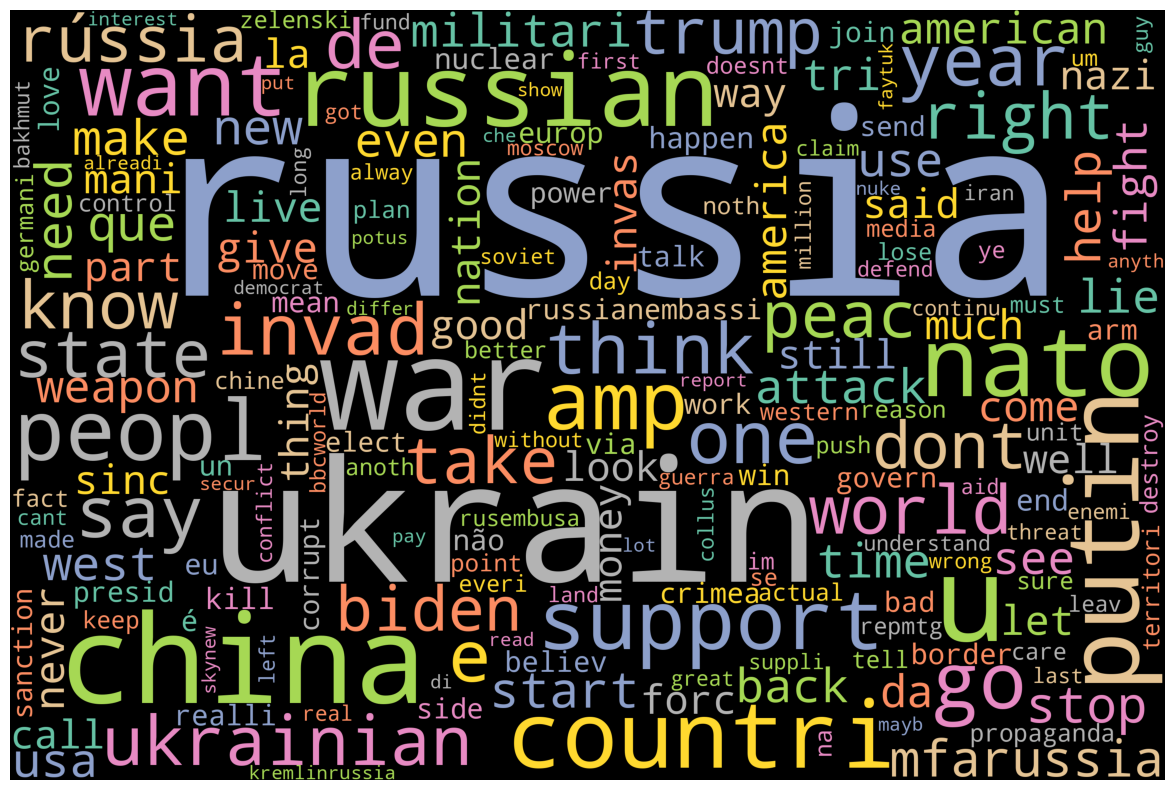

In [16]:
#@title 1.6.1 Building a Wordcloud of the tweets, which will show the most frequently used words in the tweets by people sharing their feelings and updates about the Russia-Ukraine War.

text = " ".join(i for i in data.tweet)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=3000, height=2000, stopwords=stopwords, background_color="black", colormap='Set2', collocations=False).generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [17]:
#@title 1.6.2 Building a Pie Chart showing the proportion of the sentiment in people's tweets.

import plotly.express as px

# Create a Pie Chart using Plotly
fig = px.pie(counts_df, values='Counts', names=counts_df.index,
             labels={'Category': 'Sentiment Category', 'Counts': 'Count'},
             title='Distribution of Sentiment Categories in Comments',
             hole=0.3,
             color_discrete_sequence=px.colors.qualitative.Set1)

# Set the background color of the Pie Chart to dark grey
fig.update_layout(paper_bgcolor='darkgrey')


# Show the Plotly Pie Chart
fig.show()

<ipython-input-18-f9b3de24193c>:12: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2511: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-18-f9b3de24193c>:12: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new 

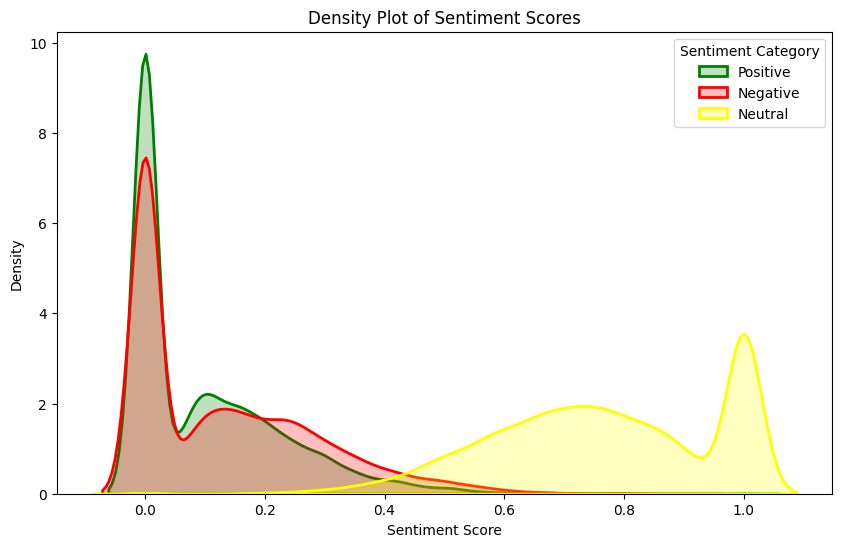

In [18]:
#@title 1.6.3 Building a Density Plot of the Sentiment Scores.

# Define the sentiment categories and corresponding colors
sentiment_categories = ["Positive", "Negative", "Neutral"]
colors = ['green', 'red', 'yellow']

# Set up the plot
plt.figure(figsize=(10, 6))

# Iterate over sentiment categories and plot KDE
for category, color in zip(sentiment_categories, colors):
    sns.distplot(data[category], hist=False, kde=True,
                 bins=int(180/5), color=color,
                 hist_kws={'edgecolor': 'black'},
                 kde_kws={'shade': True, 'linewidth': 2}, label=category)

# Set plot labels and legend
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.title('Density Plot of Sentiment Scores')
plt.legend(title='Sentiment Category')

# Show the plot
plt.show()

<ipython-input-22-7657e39c3ffe>:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2511: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




<Axes: xlabel='Compound', ylabel='Density'>

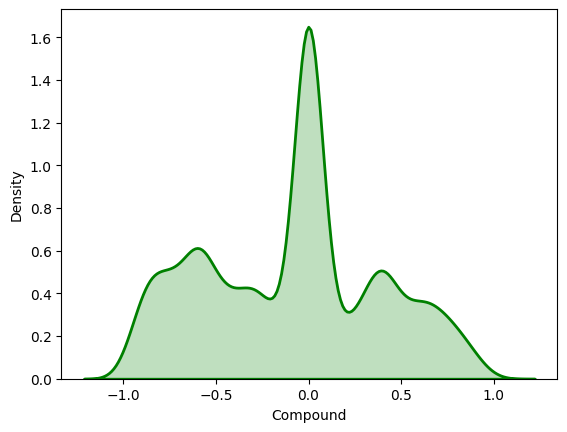

In [22]:
#@title Building a Visualization of the Sentiment Scores.

sns.distplot(data["Compound"], hist=False, kde=True,
             bins=int(180/5), color = 'green',
             hist_kws={'edgecolor':'black'},
             kde_kws={'shade': True,'linewidth': 2})

In [23]:
data.head()

,tweet,Compound,Positive,Negative,Neutral,Category
0,nazijaeg derwen russia place satan rule well,0.2732,0.259,0.000,0.741,Neutral
1,russia haarp could destroy usa one fell swoop ...,-0.5423,0.000,0.280,0.720,Negative
2,putin give steven seagal order friendship,0.4404,0.367,0.000,0.633,Neutral
3,mainelif baddcompani it alway project russia,0.0000,0.000,0.000,1.000,Neutral
4,pottingpink mfarussia modrussia milhistrf muze...,-0.0772,0.068,0.078,0.854,Neutral


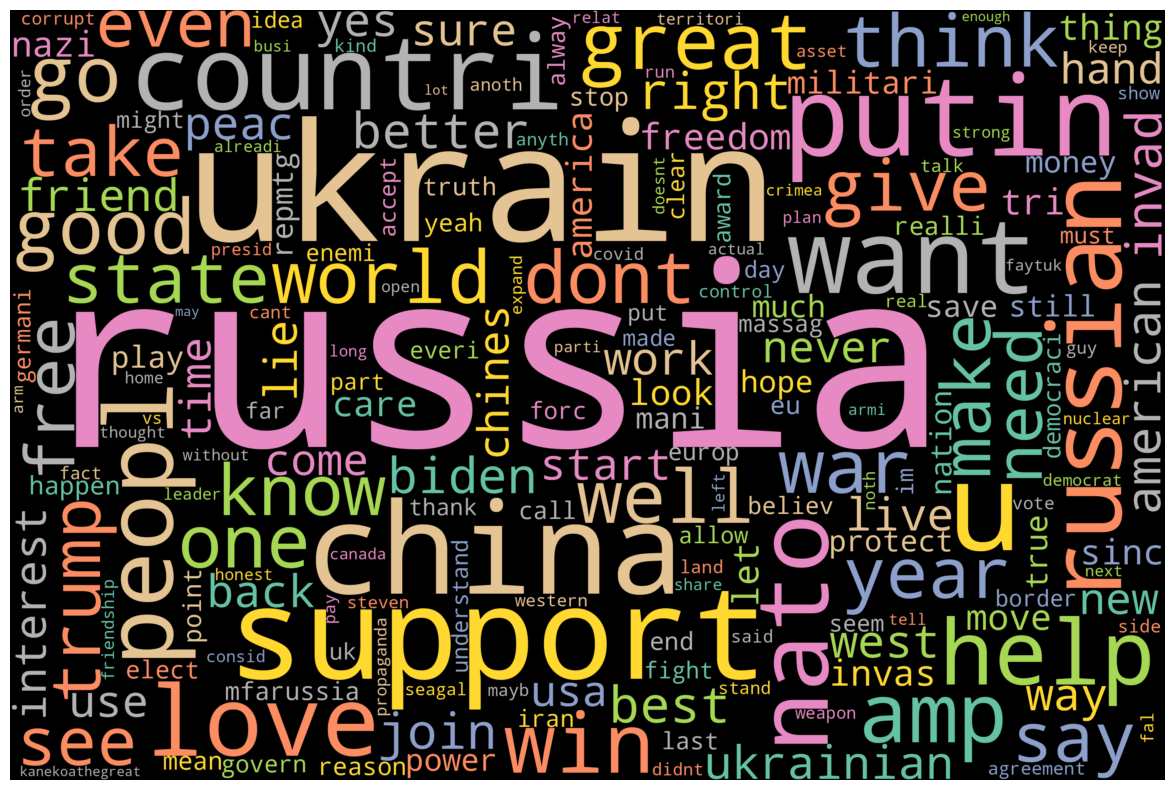

In [37]:
#@title Building a Wordcloud of the most frequently used words with positive sentiments.

positive =' '.join([i for i in data['tweet'][data['Category'] =='Positive']])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=3000, height=2000, stopwords=stopwords, background_color="black", colormap='Set2', collocations=False).generate(positive)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

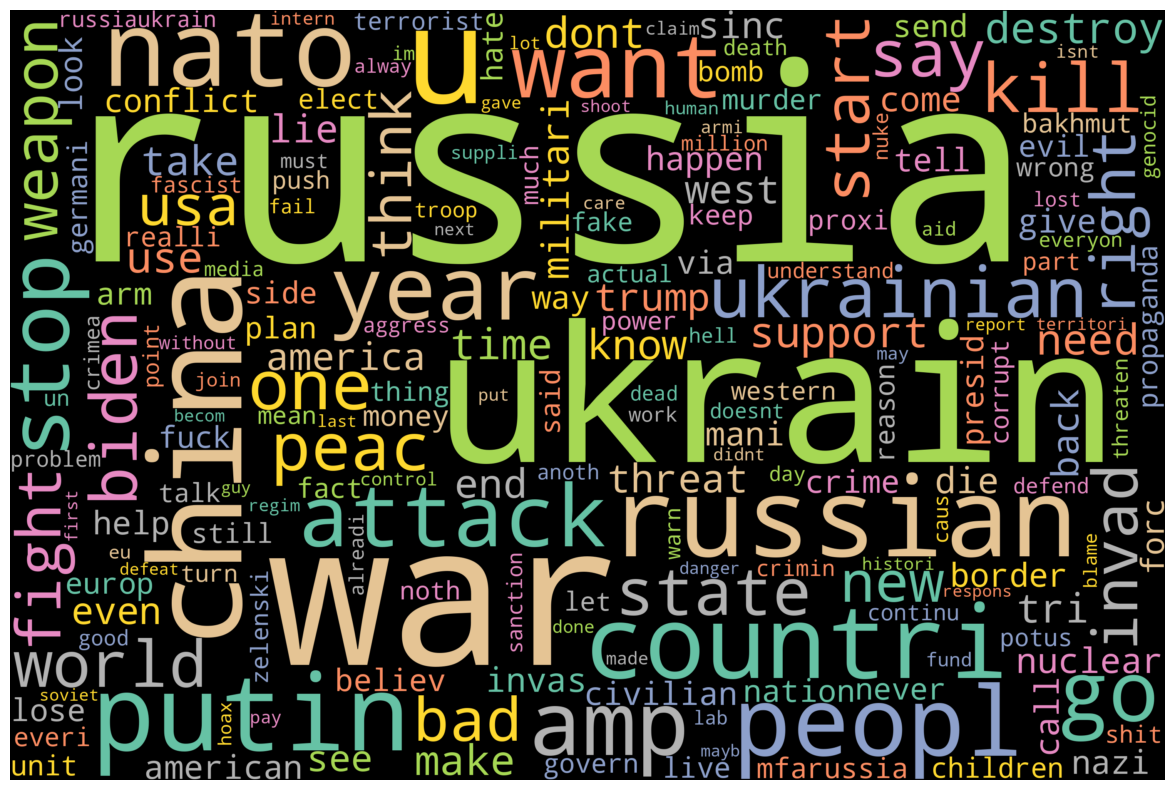

In [39]:
#@title Building a Wordcloud of the most frequently used words with negative sentiments.

negative =' '.join([i for i in data['tweet'][data['Category'] == "Negative"]])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=3000, height=2000, stopwords=stopwords, background_color="black", colormap='Set2', collocations=False).generate(negative)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

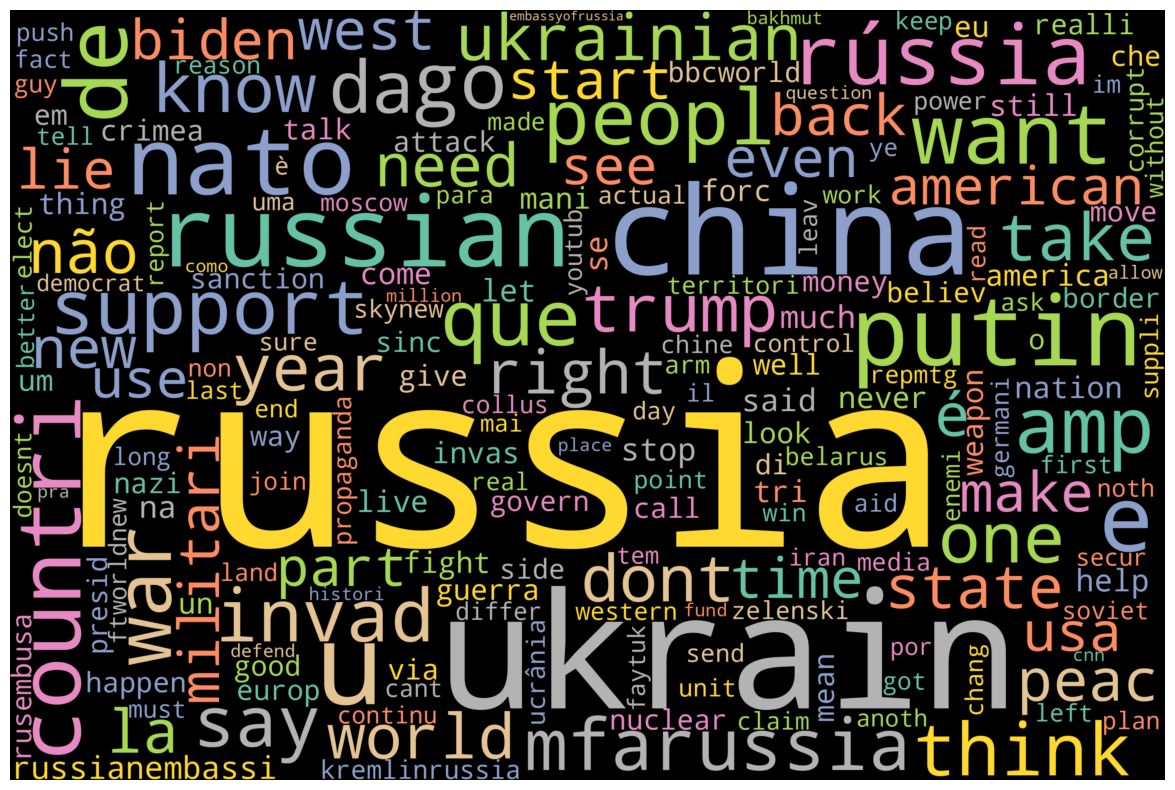

In [42]:
#@title Building a Wordcloud of the most frequently used words with neutral sentiments.

neutral =' '.join([i for i in data['tweet'][data['Category'] == "Neutral"]])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=3000, height=2000, stopwords=stopwords, background_color="black", colormap='Set2', collocations=False).generate(neutral)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()